In [18]:
!pip install -U imbalanced-learn -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score

In [14]:
# Setting visualization style
sns.set_theme(style="whitegrid")

# Loading the dataset from the provided path
df = pd.read_csv('/content/UCI_Credit_Card.csv')

In [15]:
  # 1. Handling inconsistent categories in EDUCATION (0, 5, 6 are undocumented, moving them to 'Others' category 4)
df['EDUCATION'] = df['EDUCATION'].replace([0, 5, 6], 4)

# 2. Handling inconsistent categories in MARRIAGE (0 is undocumented, moving it to 'Others' category 3)
df['MARRIAGE'] = df['MARRIAGE'].replace(0, 3)

# 3. Dropping the ID column as it provides no predictive power and prevents potential overfitting
df.drop('ID', axis=1, inplace=True)

# Displaying basic stats to ensure no nulls are present (as per initial dataset check)
print("Data Cleaning Complete. Current Shape:", df.shape)

Data Cleaning Complete. Current Shape: (30000, 24)


In [16]:
  # Defining Features (X) and Target (y)
X = df.drop('default.payment.next.month', axis=1)
y = df['default.payment.next.month']

# Splitting data BEFORE any transformation to strictly avoid Data Leakage
# Stratify ensures the proportion of default/non-default is preserved in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [19]:
# Identifying column types for targeted preprocessing
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = ['SEX', 'EDUCATION', 'MARRIAGE']

# Preprocessing for numerical data: Handle outliers using RobustScaler
numeric_transformer = Pipeline(steps=[
    ('scaler', RobustScaler())
])

# Preprocessing for categorical data: Convert to binary vectors via One-Hot Encoding
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combining both transformers into a single preprocessor engine
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [20]:
  # Defining a list of models for comparison
models = {
    "Logistic_Regression": LogisticRegression(max_iter=1000),
    "Random_Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', learning_rate=0.05)
}

# Dictionary to store results
results = {}

for name, model in models.items():
    # Constructing a pipeline that includes Preprocessing -> SMOTE -> Classifier
    # SMOTE is applied only during fit(), preventing leakage into validation
    full_pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)
    ])

    # Training the model
    full_pipeline.fit(X_train, y_train)

    # Making predictions
    y_pred = full_pipeline.predict(X_test)

    print(f"\n--- Model: {name} ---")
    print(classification_report(y_test, y_pred))
    results[name] = full_pipeline


--- Model: Logistic_Regression ---
              precision    recall  f1-score   support

           0       0.87      0.68      0.76      4673
           1       0.36      0.63      0.46      1327

    accuracy                           0.67      6000
   macro avg       0.61      0.66      0.61      6000
weighted avg       0.75      0.67      0.69      6000


--- Model: Random_Forest ---
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      4673
           1       0.55      0.47      0.50      1327

    accuracy                           0.80      6000
   macro avg       0.70      0.68      0.69      6000
weighted avg       0.79      0.80      0.79      6000


--- Model: XGBoost ---
              precision    recall  f1-score   support

           0       0.86      0.87      0.87      4673
           1       0.52      0.51      0.52      1327

    accuracy                           0.79      6000
   macro avg       0.69      0.69     

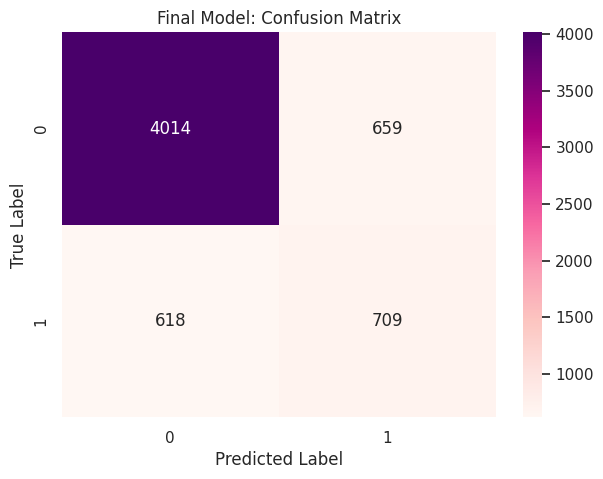

Best Parameters Found: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__n_estimators': 200}

Final Optimized Report:
               precision    recall  f1-score   support

           0       0.87      0.86      0.86      4673
           1       0.52      0.53      0.53      1327

    accuracy                           0.79      6000
   macro avg       0.69      0.70      0.69      6000
weighted avg       0.79      0.79      0.79      6000



In [21]:
# Fine-tuning the best model (XGBoost) using Grid Search
param_grid = {
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__max_depth': [3, 5],
    'classifier__n_estimators': [100, 200]
}

grid_search = GridSearchCV(results['XGBoost'], param_grid, cv=3, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Final evaluation on the test set
final_model = grid_search.best_estimator_
y_final_pred = final_model.predict(X_test)

# Plotting Confusion Matrix for the final report
plt.figure(figsize=(7,5))
sns.heatmap(confusion_matrix(y_test, y_final_pred), annot=True, fmt='d', cmap='RdPu')
plt.title('Final Model: Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("Best Parameters Found:", grid_search.best_params_)
print("\nFinal Optimized Report:\n", classification_report(y_test, y_final_pred))

In [27]:
# Create a new sample matching the features format
new_client = pd.DataFrame([{
    'LIMIT_BAL': 20000, 'SEX': 2, 'EDUCATION': 2, 'MARRIAGE': 1, 'AGE': 24,
    'PAY_0': 2, 'PAY_2': 2, 'PAY_3': 0, 'PAY_4': 0, 'PAY_5': 0, 'PAY_6': 0,
    'BILL_AMT1': 18500, 'BILL_AMT2': 19000, 'BILL_AMT3': 17000, 'BILL_AMT4': 15000, 'BILL_AMT5': 14000, 'BILL_AMT6': 13000,
    'PAY_AMT1': 500, 'PAY_AMT2': 0, 'PAY_AMT3': 500, 'PAY_AMT4': 300, 'PAY_AMT5': 200, 'PAY_AMT6': 100
}])

# Use the final_model pipeline to predict
prediction = final_model.predict(new_client)
probability = final_model.predict_proba(new_client)[:, 1]

print(f"Prediction: {'Default (1)' if prediction[0]==1 else 'No Default (0)'}")
print(f"Probability of Default: {probability[0]:.2f}")

Prediction: Default (1)
Probability of Default: 0.83
